In [76]:
import pandas as pd
import torch
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest
import numpy as np

In [99]:


def create_codebook(df, units_dict=None, detailed_labels=None):
    codebook = pd.DataFrame(columns=['Name', 'Type', 'Width', 'Decimals', 'Label', 'Values', 
                                     'Missing', 'MissingRate', 'Align', 'Measure', 'Mean', 
                                     'Min', 'Max', 'StdDev', 'Median', 'Unit', 'ImbalanceWarning', 'OutlierWarning'])
    rows = []
    outlier_columns = []  # 用於儲存有離群值的欄位名稱

    for col in df.columns:
        # 初步判斷數據類型
        data_type = type(df[col].iloc[0])

        # 判斷數據類型並分類為 Scale 或 Nominal
        if pd.api.types.is_numeric_dtype(df[col]):
            measure = 'Scale'
            decimals = 2 if df[col].dtype == 'float64' else 0
            column_width = df[col].astype(str).str.len().max()  # 字符串表示的最大長度
        elif isinstance(df[col].iloc[0], (str, list)):
            measure = 'Nominal'
            decimals = 0
            column_width = df[col].astype(str).str.len().max()
        elif isinstance(df[col].iloc[0], torch.Tensor) or isinstance(df[col].iloc[0], tf.Tensor):
            measure = 'Scale'
            decimals = 2
            column_width = len(str(df[col].iloc[0]))
        else:
            measure = 'Nominal'
            decimals = 0
            column_width = len(str(df[col].iloc[0]))

        # 計算缺失值
        missing_values = df[col].isnull().sum()
        missing_rate = round(missing_values / len(df) * 100, 2)

        # 標籤為變數名稱（可以用 detailed_labels 進行更具描述性的標籤命名）
        label = detailed_labels[col] if detailed_labels and col in detailed_labels else col

        # 如果是分類變數，列出唯一值，並檢查是否存在類別不平衡
        if measure == 'Nominal':
            unique_vals = df[col].unique()
            values = ', '.join([str(val) for val in unique_vals])
            imbalance_warning = "Yes" if df[col].value_counts(normalize=True).max() > 0.8 else "No"
            outlier_warning = 'N/A'  # 對分類變數不檢查離群值
        else:
            values = 'Scale data - None'
            imbalance_warning = 'N/A'
            
            # 計算四分位距來檢測離群值
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # 判斷是否存在離群值
            outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
            outlier_rate = outliers / len(df[col]) * 100
            outlier_warning = "Yes" if outlier_rate > 5 else "No"  # 若離群值超過5%，則觸發警告

            # 如果有離群值，將欄位名稱加入列表
            if outlier_warning == "Yes":
                outlier_columns.append(col)

        # 對齊方式：數字為右對齊，字符串為左對齊
        align = 'Right' if pd.api.types.is_numeric_dtype(df[col]) else 'Left'

        # 計算數值變數的統計摘要
        if measure == 'Scale':
            mean_val = round(df[col].mean(), 2) if pd.api.types.is_numeric_dtype(df[col]) else 'N/A'
            min_val = df[col].min()
            max_val = df[col].max()
            std_dev = round(df[col].std(), 2)
            median_val = df[col].median()
        else:
            mean_val, min_val, max_val, std_dev, median_val = 'N/A', 'N/A', 'N/A', 'N/A', 'N/A'

        # 單位（可根據變數名稱或使用者提供的 units_dict 進行設置）
        unit = units_dict[col] if units_dict and col in units_dict else 'N/A'

        # 添加行到資料字典
        rows.append({
            'Name': col,
            'Type': str(data_type),
            'Width': column_width,
            'Decimals': decimals,
            'Label': label,
            'Values': values,
            'Missing': missing_values,
            'MissingRate': f'{missing_rate}%',
            'Align': align,
            'Measure': measure,
            'Mean': mean_val,
            'Min': min_val,
            'Max': max_val,
            'StdDev': std_dev,
            'Median': median_val,
            'Unit': unit,
            'ImbalanceWarning': imbalance_warning,
            'OutlierWarning': outlier_warning
        })

    # 使用 pd.concat() 創建資料字典 DataFrame
    codebook = pd.concat([pd.DataFrame([row]) for row in rows], ignore_index=True)

    # 繪製有離群值的欄位
    if outlier_columns:
        plot_outlier_columns(df, outlier_columns)

    return codebook

# 定義一個函數來對有離群值的欄位進行 KDE 和假設檢定的視覺化
def plot_outlier_columns(df, outlier_columns):
    # 設定每行的圖表數量，這裡設置為 2 個
    n_cols_per_row = 2
    n_outliers = len(outlier_columns)
    n_rows = (n_outliers + n_cols_per_row - 1) // n_cols_per_row  # 計算需要的行數

    fig, axes = plt.subplots(n_rows, n_cols_per_row, figsize=(12, 3 * n_rows))  # 動態生成子圖
    axes = axes.flatten()  # Flatten 確保每一個 subplot 都可以迭代

    for i, col in enumerate(outlier_columns):
        ax = axes[i]

        # KDE 繪製
        sns.kdeplot(df[col], color='blue', label=f"{col} KDE", fill=True, ax=ax)

        # 計算 IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 假設檢定 - 常態性檢查
        stat, p_value = normaltest(df[col].dropna())
        
        # 提取統計數據
        mean_val = round(df[col].mean(), 2)
        std_dev = round(df[col].std(), 2)
        min_val = df[col].min()
        max_val = df[col].max()

        # 標註 p-value 和統計摘要
        ax.set_title(f'KDE Plot of {col} with Outliers\n'
                     f'Name: {col}, Mean: {mean_val}, StdDev: {std_dev}, Min: {min_val}, Max: {max_val}\n'
                     f'Normality Test p-value: {p_value:.4f}')
        ax.axvline(x=lower_bound, color='green', linestyle='--', label='Lower Bound (1.5 * IQR)')
        ax.axvline(x=upper_bound, color='red', linestyle='--', label='Upper Bound (1.5 * IQR)')
        
        # 顯示離群值
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        ax.scatter(outliers[col], np.zeros(len(outliers)), color='red', label='Outliers', zorder=5)

        # 設置圖例
        ax.legend()

    # 隱藏空白子圖（如果有）
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # 調整圖表佈局
    plt.tight_layout()
    plt.show()



In [100]:
# 加载Titanic数据集
path = r'C:\Users\xdxd2\Documents\GitHub\iSpan_python-DA-cookbooks\advance\competition\Inferential_Statistics\case\train.csv'
df = pd.read_csv(path, encoding="utf-8-sig")

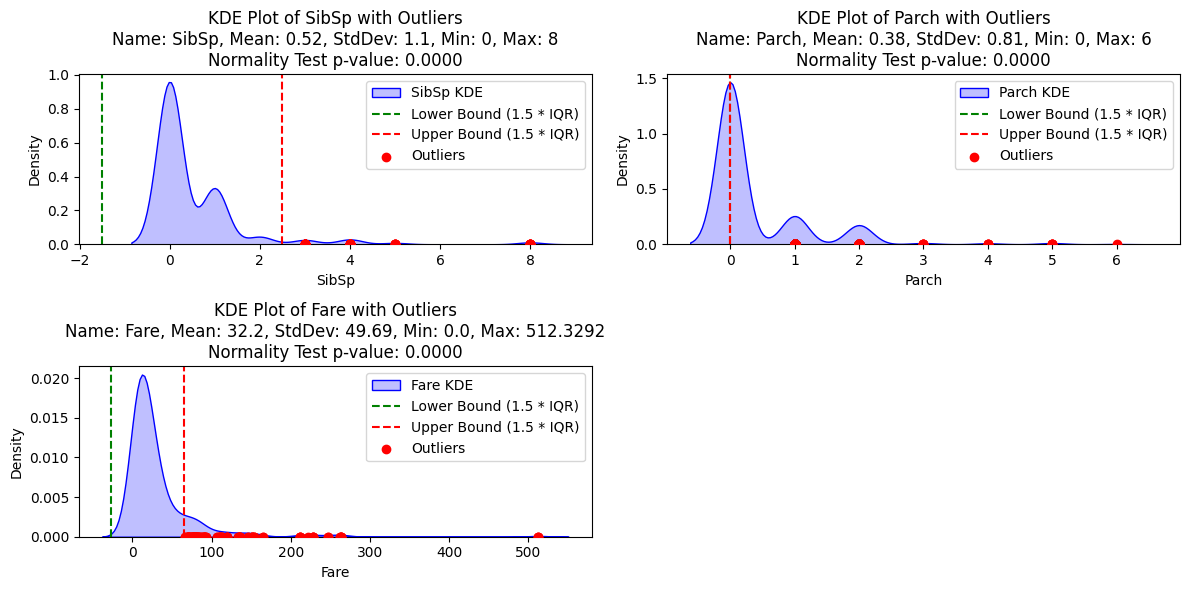

Name                     Type  Width  Decimals        Label  \
0   PassengerId    <class 'numpy.int64'>      3         0  PassengerId   
1      Survived    <class 'numpy.int64'>      1         0     Survived   
2        Pclass    <class 'numpy.int64'>      1         0       Pclass   
3          Name            <class 'str'>     82         0         Name   
4           Sex            <class 'str'>      6         0          Sex   
5           Age  <class 'numpy.float64'>      4         2          Age   
6         SibSp    <class 'numpy.int64'>      1         0        SibSp   
7         Parch    <class 'numpy.int64'>      1         0        Parch   
8        Ticket            <class 'str'>     18         0       Ticket   
9          Fare  <class 'numpy.float64'>      8         2         Fare   
10        Cabin          <class 'float'>      3         0        Cabin   
11     Embarked            <class 'str'>      3         0     Embarked   

                                               Values  Missing MissingRate  \
0                                   Scale data - None        0        0.0%   
1                                   Scale data - None        0        0.0%   
2                                   Scale data - None        0        0.0%   
3   Braund, Mr. Owen Harris, Cumings, Mrs. John Br...        0        0.0%   
4                                        male, female        0        0.0%   
5                                   Scale data - None      177      19.87%   
6                                   Scale data - None        0        0.0%   
7                                   Scale data - None        0        0.0%   
8   A/5 21171, PC 17599, STON/O2. 3101282, 113803,...        0        0.0%   
9                                   Scale data - None        0        0.0%   
10  nan, C85, C123, E46, G6, C103, D56, A6, C23 C2...      687       77.1%   
11                                       S, C, Q, nan        2       0.22%   

    Align  Measure   Mean   Min       Max  StdDev   Median Unit  \
0   Right    Scale  446.0     1       891  257.35    446.0  N/A   
1   Right    Scale   0.38     0         1    0.49      0.0  N/A   
2   Right    Scale   2.31     1         3    0.84      3.0  N/A   
3    Left  Nominal    N/A   N/A       N/A     N/A      N/A  N/A   
4    Left  Nominal    N/A   N/A       N/A     N/A      N/A  N/A   
5   Right    Scale   29.7  0.42      80.0   14.53     28.0  N/A   
6   Right    Scale   0.52     0         8     1.1      0.0  N/A   
7   Right    Scale   0.38     0         6    0.81      0.0  N/A   
8    Left  Nominal    N/A   N/A       N/A     N/A      N/A  N/A   
9   Right    Scale   32.2   0.0  512.3292   49.69  14.4542  N/A   
10   Left  Nominal    N/A   N/A       N/A     N/A      N/A  N/A   
11   Left  Nominal    N/A   N/A       N/A     N/A      N/A  N/A   

   ImbalanceWarning OutlierWarning  
0               N/A             No  
1               N/A             No  
2               N/A             No  
3                No            N/A  
4                No            N/A  
5               N/A             No  
6               N/A            Yes  
7               N/A            Yes  
8                No            N/A  
9               N/A            Yes  
10               No            N/A  
11               No            N/A

In [101]:
create_codebook(df)

## add unit and detailed_labels to the codebook

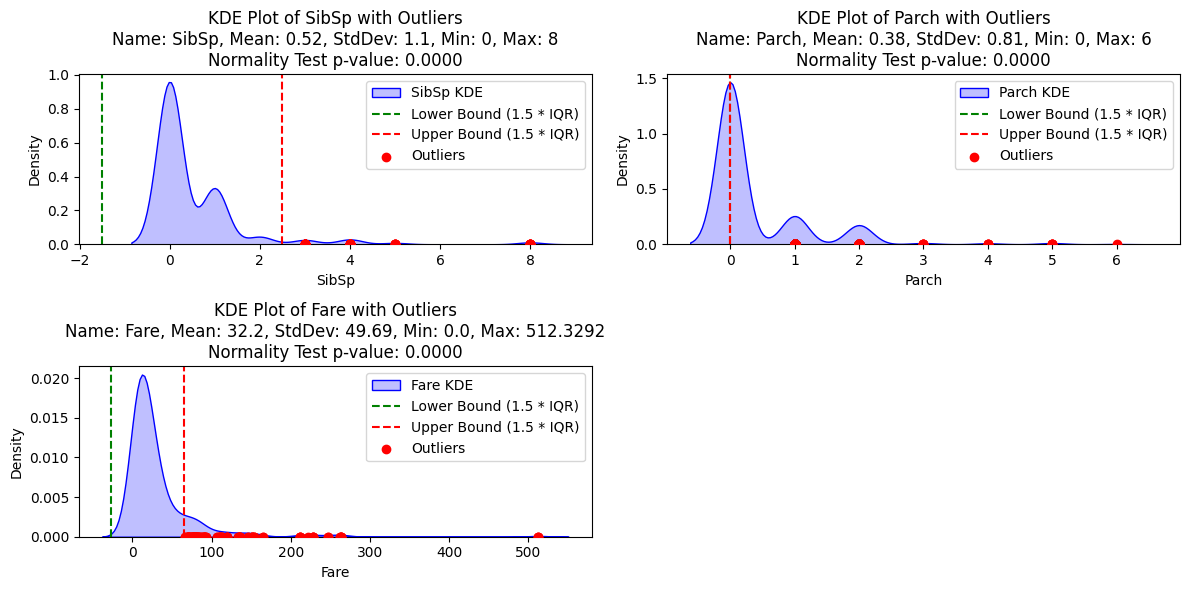

Name                     Type  Width  Decimals  \
0   PassengerId    <class 'numpy.int64'>      3         0   
1      Survived    <class 'numpy.int64'>      1         0   
2        Pclass    <class 'numpy.int64'>      1         0   
3          Name            <class 'str'>     82         0   
4           Sex            <class 'str'>      6         0   
5           Age  <class 'numpy.float64'>      4         2   
6         SibSp    <class 'numpy.int64'>      1         0   
7         Parch    <class 'numpy.int64'>      1         0   
8        Ticket            <class 'str'>     18         0   
9          Fare  <class 'numpy.float64'>      8         2   
10        Cabin          <class 'float'>      3         0   
11     Embarked            <class 'str'>      3         0   

                                                Label  \
0                                Passenger Identifier   
1                   Survival Status (0 = No, 1 = Yes)   
2            Ticket Class (1 = 1st, 2 = 2nd, 3 = 3rd)   
3                                      Passenger Name   
4                                              Gender   
5                                    Age of Passenger   
6                   Number of Siblings/Spouses Aboard   
7                   Number of Parents/Children Aboard   
8                                       Ticket Number   
9                                      Passenger Fare   
10                                       Cabin Number   
11  Port of Embarkation (C = Cherbourg; Q = Queens...   

                                               Values  Missing MissingRate  \
0                                   Scale data - None        0        0.0%   
1                                   Scale data - None        0        0.0%   
2                                   Scale data - None        0        0.0%   
3   Braund, Mr. Owen Harris, Cumings, Mrs. John Br...        0        0.0%   
4                                        male, female        0        0.0%   
5                                   Scale data - None      177      19.87%   
6                                   Scale data - None        0        0.0%   
7                                   Scale data - None        0        0.0%   
8   A/5 21171, PC 17599, STON/O2. 3101282, 113803,...        0        0.0%   
9                                   Scale data - None        0        0.0%   
10  nan, C85, C123, E46, G6, C103, D56, A6, C23 C2...      687       77.1%   
11                                       S, C, Q, nan        2       0.22%   

    Align  Measure   Mean   Min       Max  StdDev   Median       Unit  \
0   Right    Scale  446.0     1       891  257.35    446.0  ID number   
1   Right    Scale   0.38     0         1    0.49      0.0        N/A   
2   Right    Scale   2.31     1         3    0.84      3.0        N/A   
3    Left  Nominal    N/A   N/A       N/A     N/A      N/A        N/A   
4    Left  Nominal    N/A   N/A       N/A     N/A      N/A        N/A   
5   Right    Scale   29.7  0.42      80.0   14.53     28.0      years   
6   Right    Scale   0.52     0         8     1.1      0.0      count   
7   Right    Scale   0.38     0         6    0.81      0.0      count   
8    Left  Nominal    N/A   N/A       N/A     N/A      N/A        N/A   
9   Right    Scale   32.2   0.0  512.3292   49.69  14.4542        USD   
10   Left  Nominal    N/A   N/A       N/A     N/A      N/A        N/A   
11   Left  Nominal    N/A   N/A       N/A     N/A      N/A        N/A   

   ImbalanceWarning OutlierWarning  
0               N/A             No  
1               N/A             No  
2               N/A             No  
3                No            N/A  
4                No            N/A  
5               N/A             No  
6               N/A            Yes  
7               N/A            Yes  
8                No            N/A  
9               N/A            Yes  
10               No            N/A  
11               No            N/A

In [102]:
units_dict = {
    'Age': 'years',
    'Fare': 'USD',
    'PassengerId': 'ID number',
    'SibSp': 'count',   # 兄弟姐妹/配偶數量
    'Parch': 'count'    # 父母/子女數量
}

detailed_labels = {
    'PassengerId': 'Passenger Identifier',
    'Survived': 'Survival Status (0 = No, 1 = Yes)',
    'Pclass': 'Ticket Class (1 = 1st, 2 = 2nd, 3 = 3rd)',
    'Name': 'Passenger Name',
    'Sex': 'Gender',
    'Age': 'Age of Passenger',
    'SibSp': 'Number of Siblings/Spouses Aboard',
    'Parch': 'Number of Parents/Children Aboard',
    'Ticket': 'Ticket Number',
    'Fare': 'Passenger Fare',
    'Cabin': 'Cabin Number',
    'Embarked': 'Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)'
}

create_codebook(df, units_dict, detailed_labels)